<h1> unsupervised learning using Kmeans</h1>
various imports

In [1]:

import os
import gc
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from numba import cuda
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
#from tensorflow.keras.preprocessing import image

from utilities import VGG16_features, path_discovery, pca_extraction, input_preprocessing

In [3]:
# Load pre-trained VGG16 model + higher level layers
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

# New TensorFlow 2.x configuration

with tf.device('/CPU:0'):
    base_model = VGG16(weights='imagenet', include_top=True)




<h2>select feature extraction method</h2>

function to visualize and extract features with vgg16

In [4]:
# Example usage
#features = VGG16_features('images_dataset/apple fruit/image_26.jpg', base_model, layer_name='block4_conv3',visualize=False)
#print("Extracted Features Shape:", features.shape)

#Existing layers are: ['input_1', 'block1_conv1-2', 'block1_pool', 'block2_conv1-2', 'block2_pool',
#'block3_conv1-2-3', 'block3_pool', 'block4_conv1-2-3', 'block4_pool', 'block5_conv1-2-3', 'block5_pool', 'flatten', 'fc1', 'fc2', 'fc2'].

extracted_feature_list=[]

res = path_discovery('images_dataset/')

for i in res.img_paths:
    features = VGG16_features(i, base_model, layer_name='fc2',visualize=False)
    extracted_feature_list.append(features)


extracted_feature_list = np.array(extracted_feature_list)
eval_image_names = np.array(res.img_paths)
dirs_visited = np.array(res.dirs_visited)
print("features shape",extracted_feature_list.shape)

with open('features_labels.pkl', 'wb') as f:
    pickle.dump((extracted_feature_list, eval_image_names, res.labels,dirs_visited), f)

 
del res

1/1 [==============================] - 0s 182ms/step
features shape (360, 4096)


function to extract features with autoencoder (must be trained)

In [2]:
#WARNING the model that is loaded must be present in working directory, if not, it means it must be trained first
#go to last code cell to train the autoencoder model

paths=path_discovery('images_dataset')
eval_image_names = np.array(paths.img_paths)
dirs_visited = np.array(paths.dirs_visited)
res=input_preprocessing(paths.img_paths)

feature_vector= np.array(res.feature_vector)
feature_vector=feature_vector/255

with tf.device('/CPU:0'):
    encoder= tf.keras.models.load_model('autoencoder_model')
    encoder_model= Model(inputs=encoder.input, outputs=encoder.get_layer('bottleneck').output)
    extracted_feature_list=encoder_model.predict(feature_vector)
print("features shape",extracted_feature_list.shape)

with open('features_labels.pkl', 'wb') as f:
    pickle.dump((extracted_feature_list, eval_image_names, paths.labels,dirs_visited), f)

input preprocessing...
preprocessing done
12/12 [==============================] - 0s 21ms/step
features shape (360, 512)


<h2>model Kmeans training, with PCA reduced features</h2>
(labels are included for evaluation of accuracy)

array1 features (360, 512)
number of PCA components explaining 80.0% of variance: 7


c:\Users\frenc\miniconda3\envs\test-lab\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


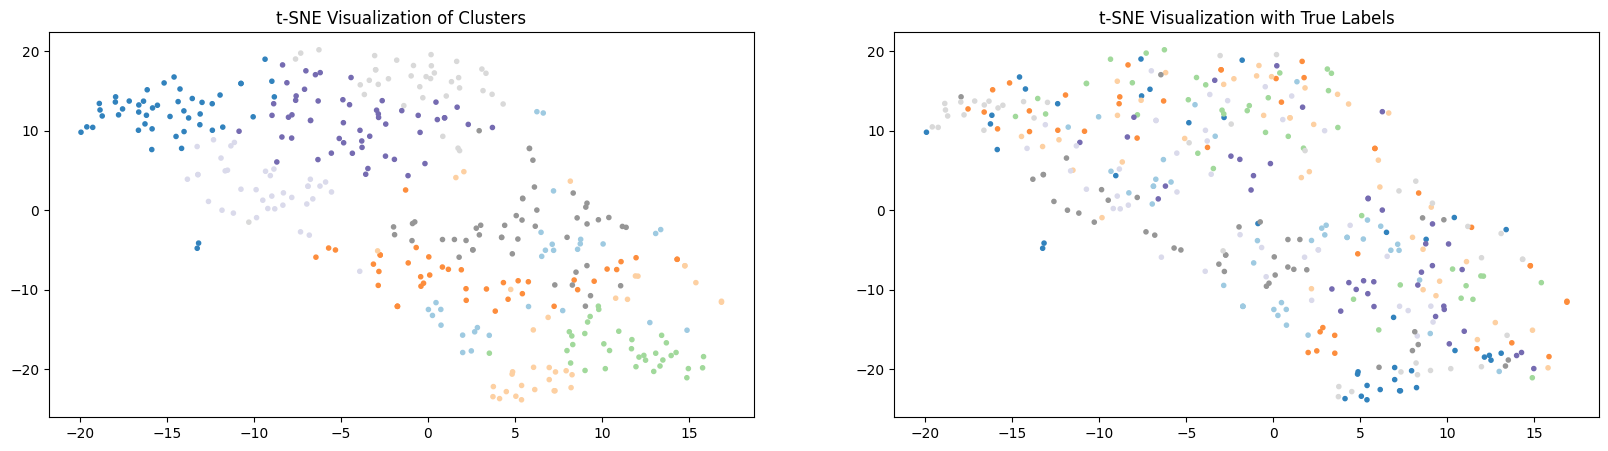

Precision: 0.2685019465380999
Recall: 0.26666666666666666
Accuracy: 0.26666666666666666


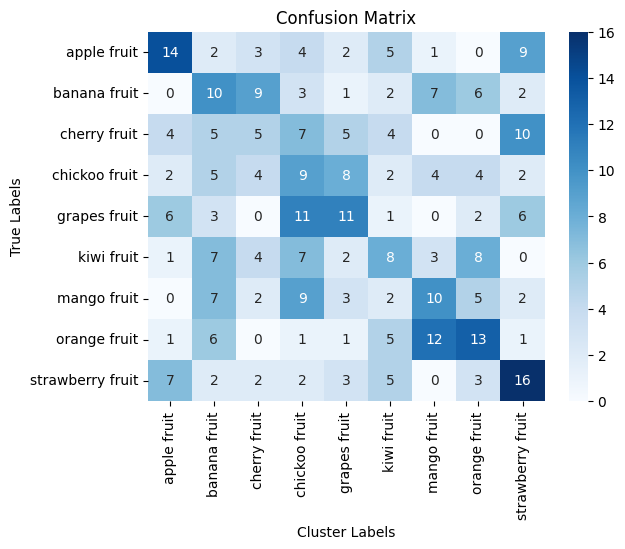

Misclassified Images:
images_dataset\apple fruit\Image_10.jpg
images_dataset\apple fruit\Image_12.jpg
images_dataset\apple fruit\Image_14.png
images_dataset\apple fruit\Image_15.jpg
images_dataset\apple fruit\Image_16.jpg
images_dataset\apple fruit\Image_17.jpeg
images_dataset\apple fruit\Image_18.jpg
images_dataset\apple fruit\Image_19.jpg
images_dataset\apple fruit\Image_2.jpg
images_dataset\apple fruit\Image_20.jpg
images_dataset\apple fruit\Image_22.jpg
images_dataset\apple fruit\Image_23.png
images_dataset\apple fruit\Image_24.jpg
images_dataset\apple fruit\Image_25.jpg
images_dataset\apple fruit\Image_26.jpg
images_dataset\apple fruit\Image_27.jpg
images_dataset\apple fruit\Image_29.jpg
images_dataset\apple fruit\Image_31.png
images_dataset\apple fruit\Image_34.jpeg
images_dataset\apple fruit\Image_35.jpg
images_dataset\apple fruit\Image_37.jpg
images_dataset\apple fruit\Image_38.jpg
images_dataset\apple fruit\Image_39.jpg
images_dataset\apple fruit\Image_4.jpg
images_dataset\app

In [3]:

with open('features_labels.pkl', 'rb') as f:
    extracted_feature_list, eval_image_names, labels, dirs_visited = pickle.load(f)
print("array1 features",extracted_feature_list.shape)

#feature reduction 2D using tsne (for visualization only)
tsne = TSNE(n_components=2)
pca_object=pca_extraction(extracted_feature_list,0.8)
tsne_result=tsne.fit_transform(pca_object.pca_result)

#Kmeans clustering using PCA reduced features
Kmeans= KMeans(n_clusters=9,init='k-means++')
Kmeans.fit(pca_object.pca_result)
Kmeans_labels=Kmeans.labels_

#  Visualize the clustering results
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=Kmeans_labels, cmap='tab20c',s=9)
plt.title('t-SNE Visualization of Clusters')

#  Compare with true labels
plt.subplot(1,2,2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab20c',s=9)
plt.title('t-SNE Visualization with True Labels')
plt.show()

#clustering result
accuracy=adjusted_rand_score(Kmeans_labels,labels)

#confusion matrix
conf_matrix = confusion_matrix(labels, Kmeans_labels)

#creating a dictionary that maps the "cluster labels" number to the most likely correct "true labels" number
row_ind, col_ind = linear_sum_assignment(-conf_matrix)
label_mapping = dict(zip(col_ind, row_ind))
mapped_Kmeans_labels = np.array([label_mapping[label] for label in Kmeans_labels])
remapped_conf_matrix = confusion_matrix(labels, mapped_Kmeans_labels)

#how often the positive predictions are correct?
precision = precision_score(labels, mapped_Kmeans_labels, average='weighted')
# can an ML model find all instances of the positive class?
recall = recall_score(labels, mapped_Kmeans_labels, average='weighted')
#how often the model is right? (if the class numbers are unbalanced between TP and TN, the accuracy will fail)
accuracy = accuracy_score(labels, mapped_Kmeans_labels)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

#retrieve class names from the path discovery at beginning
dirs_basename= [os.path.basename(d) for d in dirs_visited]

# Visualize the remapped confusion matrix using a heatmap
sns.heatmap(remapped_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dirs_basename[1:len(dirs_basename)],
            yticklabels=dirs_basename[1:len(dirs_basename)])
plt.xlabel('Cluster Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

missed_images=[]
missed_indices= np.where(labels != mapped_Kmeans_labels)[0]
missed_images = eval_image_names[missed_indices]

print("Misclassified Images:")
for img in missed_images:
    print(img)
if 'features' in globals():
    del features
if 'extracted_feature_list' in globals():
    del extracted_feature_list

<h2>model Kmeans evaluation</h2>

In [ ]:
img_dir2='eval_dataset/'
eval_features=[]


res= path_discovery(img_dir2)

for i in res.img_paths:
    features = VGG16_features(i, base_model, layer_name='fc2',visualize=False)
    eval_features.append(features)


eval_features = np.array(eval_features)
eval_image_names = np.array(res.img_paths)
eval_image_names= [os.path.basename(d) for d in eval_image_names]


print('feature list shape', eval_features.shape)

#apply transformation matrix of PCA, previously calculated, to reduce feature vector size
eval_features=pca_object.pca.transform(eval_features)

print('reduced feature list shape', eval_features.shape)

pred_clusters=Kmeans.predict(eval_features)
#print('predicted_SVM_labels cluster',pred_clusters)

#using the mapping dictionary created in the training phase
mapped_Kmeans_labels = np.array([label_mapping[label] for label in pred_clusters])
#print('mapped predicted_SVM_labels cluster',mapped_Kmeans_labels)


remapped_conf_matrix = confusion_matrix(res.labels, mapped_Kmeans_labels)

#how often the positive predictions are correct?
precision = precision_score(res.labels, mapped_Kmeans_labels, average='weighted')
# can an ML model find all instances of the positive class?
recall = recall_score(res.labels, mapped_Kmeans_labels, average='weighted')
#ow often the model is right? (if the class numbers are unbalanced between TP and TN, the accuracy will fail)
accuracy = accuracy_score(res.labels, mapped_Kmeans_labels)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

#retrieve class names from the path discovery at beginning
dirs_basename= [os.path.basename(d) for d in res.dirs_visited]

# Visualize the remapped confusion matrix using a heatmap
sns.heatmap(remapped_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dirs_basename[1:len(dirs_basename)],
            yticklabels=dirs_basename[1:len(dirs_basename)])
plt.xlabel('Cluster Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


for a in range(len(mapped_Kmeans_labels)):
    print('real name:',eval_image_names[a], '   predicted_SVM_labels name:', dirs_basename[mapped_Kmeans_labels[a]])


del res,features,eval_features

<h2>model SVM training</h2>
(supervised method)

In [6]:
from sklearn.svm import SVC

with open('features_labels.pkl', 'rb') as f:
    extracted_feature_list, eval_image_names, labels, dirs_visited= pickle.load(f)
    
#train 9 SVM one for each class
kernel= 'linear'
max_iterations=500

models = [SVC(kernel=kernel, max_iter=max_iterations, probability=True),
          SVC(kernel=kernel, max_iter=max_iterations, probability=True),
          SVC(kernel=kernel, max_iter=max_iterations, probability=True),
          SVC(kernel=kernel, max_iter=max_iterations, probability=True),
          SVC(kernel=kernel, max_iter=max_iterations, probability=True),
          SVC(kernel=kernel, max_iter=max_iterations, probability=True),
          SVC(kernel=kernel, max_iter=max_iterations, probability=True),
          SVC(kernel=kernel, max_iter=max_iterations, probability=True),
          SVC(kernel=kernel, max_iter=max_iterations, probability=True),]


for i in range(9):
    models[i].fit(extracted_feature_list, labels==i+1)


model predictions on evaluation data

1/1 [==============================] - 0s 179ms/step
Precision: 0.9596153846153846
Recall: 0.9538461538461539
Accuracy: 0.9538461538461539


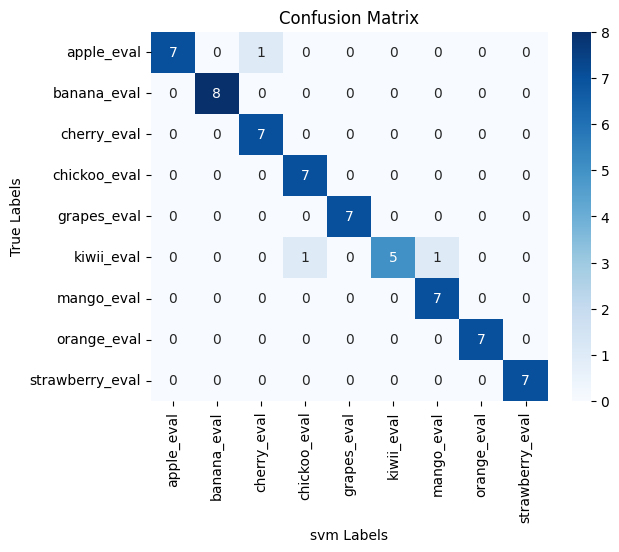

real name: apple (1).jpg    predicted name: cherry_eval
real name: apple (2).jpg    predicted name: apple_eval
real name: apple (3).jpg    predicted name: apple_eval
real name: apple (4).jpg    predicted name: apple_eval
real name: apple (5).jpg    predicted name: apple_eval
real name: apple (6).jpg    predicted name: apple_eval
real name: apple (7).jpg    predicted name: apple_eval
real name: apple (8).jpg    predicted name: apple_eval
real name: banana (1).jpg    predicted name: banana_eval
real name: banana (2).jpg    predicted name: banana_eval
real name: banana (3).jpg    predicted name: banana_eval
real name: banana (4).jpg    predicted name: banana_eval
real name: banana (5).jpg    predicted name: banana_eval
real name: banana (6).jpg    predicted name: banana_eval
real name: banana (7).jpg    predicted name: banana_eval
real name: banana (8).jpg    predicted name: banana_eval
real name: cherry (1).jpg    predicted name: cherry_eval
real name: cherry (2).jpg    predicted name: c

In [7]:
img_dir2='eval_dataset/'
eval_features=[]
res= path_discovery(img_dir2)

for i in res.img_paths:
    features = VGG16_features(i, base_model, layer_name='fc2',visualize=False)
    eval_features.append(features)


eval_features = np.array(eval_features)
eval_image_names = np.array(res.img_paths)
eval_image_names= [os.path.basename(d) for d in eval_image_names]



predict_score=[]
for i in range(9):
    #calculate probability of all samples for each model, then take only 2nd column
    #which is the prob. that the sample BELONGS to that class (wherease [:,0] is the prob. to not belong)
    predict_score.append(models[i].predict_proba(eval_features)[:,1])


predict_score=np.asarray(predict_score)
predicted_SVM_labels=np.argmax(predict_score,axis=0) +1 #because true labels start from 1

conf_matrix1= confusion_matrix(res.labels,predicted_SVM_labels)

#how often the positive predictions are correct?
precision = precision_score(res.labels, predicted_SVM_labels, average='weighted')
# can an ML model find all instances of the positive class?
recall = recall_score(res.labels, predicted_SVM_labels, average='weighted')
#ow often the model is right? (if the class numbers are unbalanced between TP and TN, the accuracy will fail)
accuracy = accuracy_score(res.labels, predicted_SVM_labels)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")


dirs_basename= [os.path.basename(d) for d in res.dirs_visited]
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dirs_basename[1:len(dirs_basename)],
            yticklabels=dirs_basename[1:len(dirs_basename)])

plt.xlabel('svm Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

for a in range(len(predicted_SVM_labels)):
    print('real name:',eval_image_names[a], '   predicted name:', dirs_basename[predicted_SVM_labels[a]])

<h2>model DBscan training with PCA reduced features</h2>

array1 features (360, 4096)
number of PCA components explaining 70.0% of variance: 34
dbscan number of clusters 20
Precision: 0.4328174603174603
Recall: 0.2876757852564304
Accuracy: 0.6642335766423357


c:\Users\frenc\miniconda3\envs\test-lab\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


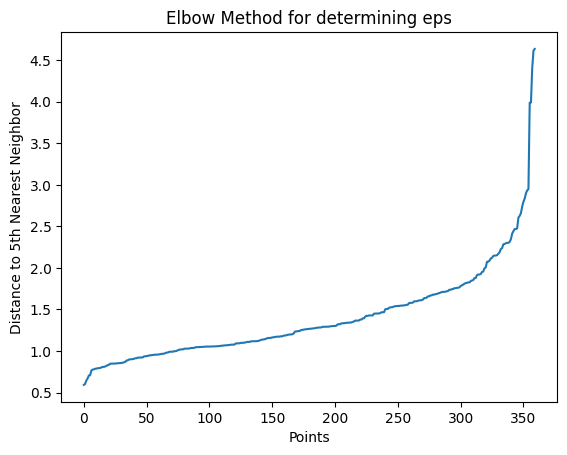

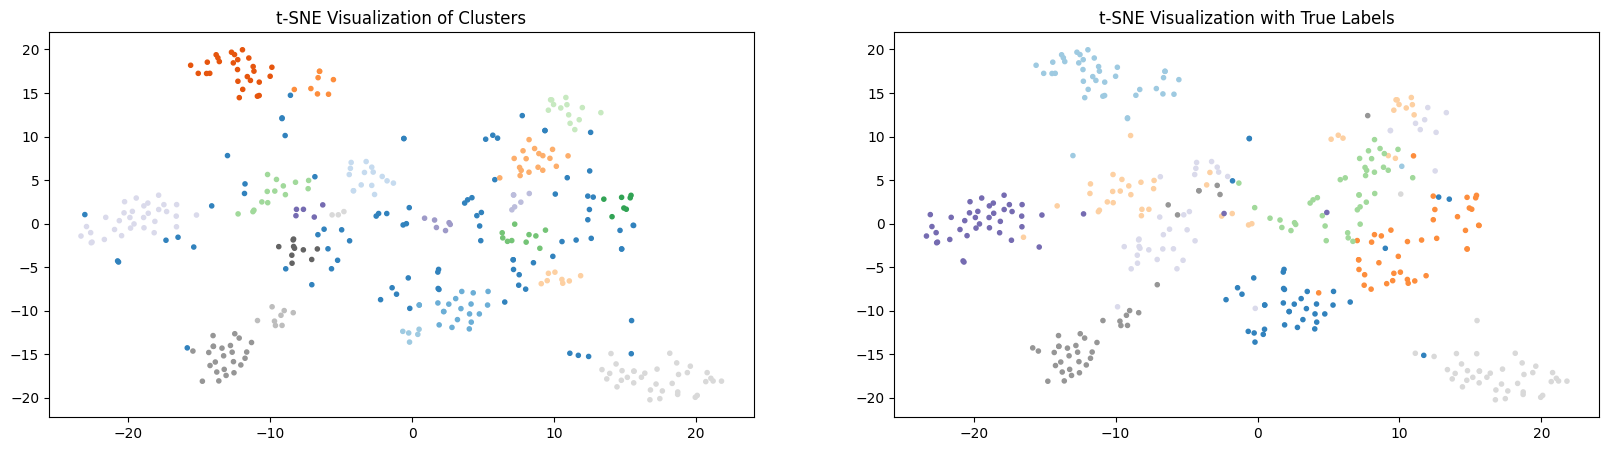

In [5]:
with open('features_labels.pkl', 'rb') as f:
    extracted_feature_list, eval_image_names, labels, dirs_visited = pickle.load(f)

print("array1 features",extracted_feature_list.shape)

#feature reduction 2D using tsne (for visualization only)
tsne = TSNE(n_components=2)
pca_object=pca_extraction(extracted_feature_list,0.7)
tsne_result=tsne.fit_transform(pca_object.pca_result)

#DBscan clustering using PCA reduced features
dbscan=DBSCAN(eps=1.5,min_samples=5)
dbscan_labels = dbscan.fit_predict(tsne_result)
print("dbscan number of clusters",np.max(dbscan_labels)+1)

mask = dbscan_labels != -1
filtered_dbscan_labels = dbscan_labels[mask]
filtered_true_labels = labels[mask]

#confusion matrix
conf_matrix = confusion_matrix(filtered_true_labels, filtered_dbscan_labels)
#creating a dictionary that maps the "cluster labels" number to the most likely correct "true labels" number
#this time the cluster labels can be more than the true labels, 
row_ind, col_ind = linear_sum_assignment(-conf_matrix)
label_mapping = dict(zip(col_ind, row_ind))
mapped_labels = np.zeros_like(filtered_dbscan_labels)
for i, j in zip(row_ind, col_ind):
    mapped_labels[filtered_dbscan_labels == j] = i


accuracy = accuracy_score(filtered_true_labels, mapped_labels)
precision = precision_score(filtered_true_labels, mapped_labels, average='macro')
recall = recall_score(filtered_true_labels, mapped_labels, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

#find the distances of each point from the first 5 nearest neighbour
#this algorithm is done to find the best value for "eps" dbscan parameter
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(tsne_result)
distances, indices = neighbors_fit.kneighbors(tsne_result)

# Sort and plot the distances of each point from the 3rd neighbour
distances = np.sort(distances, axis=0)
distances = distances[:, 3]
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distance to 5th Nearest Neighbor')
plt.title('Elbow Method for determining eps')
plt.show()

#  Visualize the clustering results
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=dbscan_labels, cmap='tab20c',s=9)
plt.title('t-SNE Visualization of Clusters')

#  Compare with true labels
plt.subplot(1,2,2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab20c',s=9)
plt.title('t-SNE Visualization with True Labels')
plt.show()




<h2>autoencoder training for feature extraction</h2>

result will be shown after process finished, check gpu memory usage

return code:  0
error 2024-07-01 11:20:52.564959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 11:20:53.092711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1229 MB memory:  -> device: 0, name: NVIDIA GeForce MX550, pci bus id: 0000:01:00.0, compute capability: 7.5

output subprocess called

Num GPUs Available:  1
input preprocessing...
preprocessing done
Shape of feature_vectors: (360, 37632)
x_train shape (288, 37632) x_val shape (72, 37632)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape    

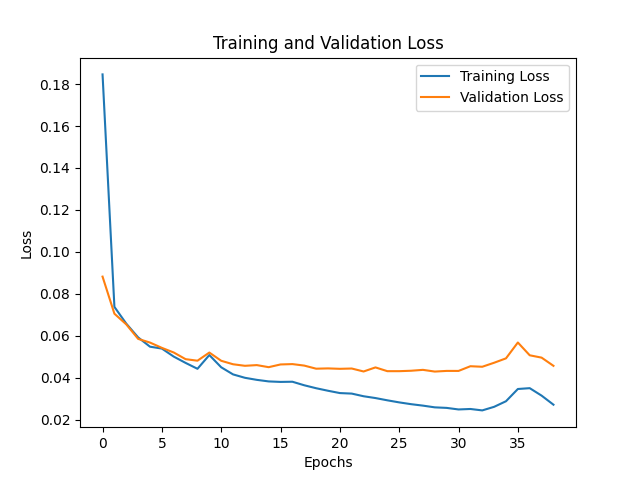

In [3]:
import subprocess
from IPython.display import display

paths = path_discovery('images_dataset/')

def run_training_subprocess(g1):
    
    print("result will be shown after process finished, check gpu memory usage\n")
    
    res = subprocess.run(["python", 'train_autoencoder.py']+g1,text=True, capture_output=True)

    print("return code: ",res.returncode)
    print("error",res.stderr)
    print("output",res.stdout)

    img = Image.open('autoencoder_val_loss.png')
    display(img)

    
encoder_result = run_training_subprocess(paths.img_paths)


<h2>model autoencoder evaluation</h2>

input preprocessing...
preprocessing done
Shape of feature_vectors: (65, 37632)
3/3 [==============================] - 0s 73ms/step


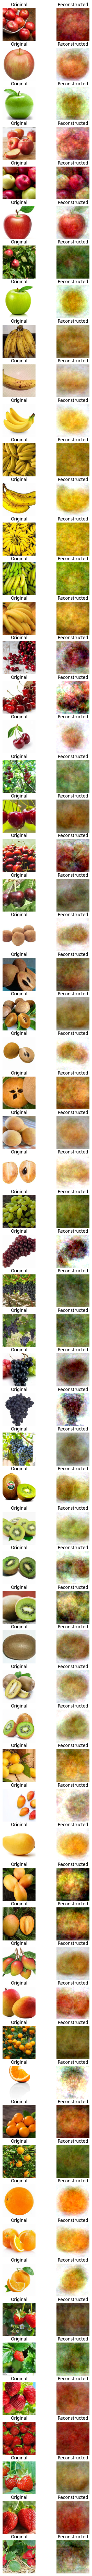

In [3]:
from tensorflow.keras.backend import clear_session


clear_session()
gc.collect()
with tf.device('/CPU:0'):
    encoder= tf.keras.models.load_model('autoencoder_model')
#encoder= ('autoencoder_model')
paths = path_discovery('eval_dataset/')

def plot_images(original_images, reconstructed_images, n):
    
    plt.figure(figsize=(5, n * 2))  # Adjust the height based on n for better spacing
    for i in range(n):
        # Original images
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed images
        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()
    
res=input_preprocessing(paths.img_paths)
        
feature_vector= np.array(res.feature_vector)
feature_vector=feature_vector/255

#h1=np.clip(res.original_image, 0, 1)   
#plot_images(h1 ,h1, len(h1) ) 

print(f"Shape of feature_vectors: {feature_vector.shape}") 


reconstructed_images=encoder.predict(feature_vector)
reconstructed_images = np.clip(reconstructed_images, 0, 1)   
reconstructed_images = reconstructed_images.reshape(-1, 112, 112,3)

plot_images(res.original_image ,reconstructed_images, len(res.original_image) ) 
